In [32]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

def csv_save(result_list: list, file_name: str):
    submission = pd.read_csv('/opt/ml/input/data/sample_submission.csv')
    submission['prediction'] = np.nan
    submission['prediction'] = result_list
    submission.to_csv('./submit/'+file_name+'.csv', index=False)


train_data = pd.read_csv('/opt/ml/input/data/train_data.csv')
test_data = pd.read_csv('/opt/ml/input/data/test_data.csv')


# 제출 데이터
submission_data = test_data[test_data['answerCode'] == -1]


# test_train 데이터 결합 [정답이 -1일 경우 제외]
test_train_data = pd.concat([train_data, test_data[(test_data['answerCode'] == 0) | (test_data['answerCode'] == 1)]],
                             ignore_index=True)
# testID 전처리
test_train_data['testId'] = test_train_data['testId'].str[1:4] + test_train_data['testId'].str[7:10]
test_train_data.nunique()

userID                 7442
assessmentItemID       9454
testId                 1537
answerCode                2
Timestamp           2293142
KnowledgeTag            912
dtype: int64

## 각각의 feature로 dict 제작

In [34]:
from collections import defaultdict

userID_dict = defaultdict(lambda: [0, 0])
assessmentItemID_dict = defaultdict(lambda: [0, 0])
KnowledgeTag_dict = defaultdict(lambda: [0, 0])

for _, row in test_train_data.iterrows():
    userID_dict[row['userID']][0] += row['answerCode']
    userID_dict[row['userID']][1] += 1

    assessmentItemID_dict[row['assessmentItemID']][0] += row['answerCode']
    assessmentItemID_dict[row['assessmentItemID']][1] += 1

    KnowledgeTag_dict[row['KnowledgeTag']][0] += row['answerCode']
    KnowledgeTag_dict[row['KnowledgeTag']][1] += 1

for key, value in userID_dict.items():
    userID_dict[key] = value[0] / value[1]
userID_dict = dict(userID_dict)

for key, value in assessmentItemID_dict.items():
    assessmentItemID_dict[key] = value[0] / value[1]
assessmentItemID_dict = dict(assessmentItemID_dict)

for key, value in KnowledgeTag_dict.items():
    KnowledgeTag_dict[key] = value[0] / value[1]
KnowledgeTag_dict = dict(KnowledgeTag_dict)


## pkl save

In [38]:
## save pkl
with open('./data/userID_dict.pkl', 'wb') as f:
    pickle.dump(dict(userID_dict), f)
with open('./data/assessmentItemID_dict.pkl', 'wb') as f:
    pickle.dump(dict(assessmentItemID_dict), f)
with open('./data/KnowledgeTag_dict.pkl', 'wb') as f:
    pickle.dump(dict(KnowledgeTag_dict), f)  

## pkl load

In [39]:
## load pkl
with open('./data/userID_dict.pkl', 'rb') as f:
    userID_dict = pickle.load(f)
with open('./data/assessmentItemID_dict.pkl', 'rb') as f:
    assessmentItemID_dict = pickle.load(f)
with open('./data/KnowledgeTag_dict.pkl', 'rb') as f:
    KnowledgeTag_dict = pickle.load(f)

## userID

In [40]:
userID_result = []
for _, row in submission_data.iterrows():
    try:
        userID_dict_value = userID_dict[row['userID']]
        userID_result.append(userID_dict_value)
    except:
        userID_result.append(np.nan)

csv_save(userID_result, 'userID')

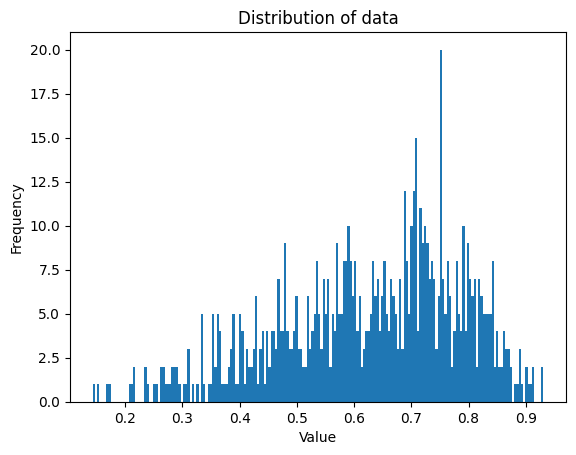

In [41]:
plt.hist(userID_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## assessmentItemID [0.7638, 0.6909]

In [42]:
assemssmentItemID_result = []
for _, row in submission_data.iterrows():
    try:
        assemssmentItemID_value = assessmentItemID_dict[row['assessmentItemID']]
        assemssmentItemID_result.append(assemssmentItemID_value)
    except:
        assemssmentItemID_result.append(np.nan)

csv_save(assemssmentItemID_result, 'assemssmentItemID')

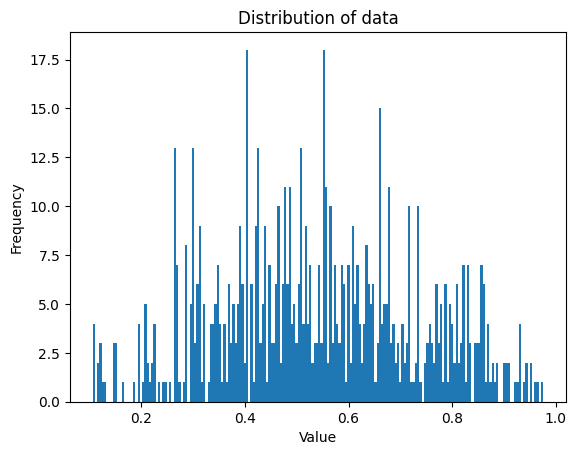

In [43]:
plt.hist(assemssmentItemID_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## KnowledgeTag

In [9]:
KnowledgeTag_result = []
for _, row in submission_data.iterrows():
    try:
        KnowledgeTag_value = KnowledgeTag_dict[row['KnowledgeTag']]
        KnowledgeTag_result.append(KnowledgeTag_value)
    except:
        KnowledgeTag_result.append(np.nan)

csv_save(KnowledgeTag_result, 'KnowledgeTag')

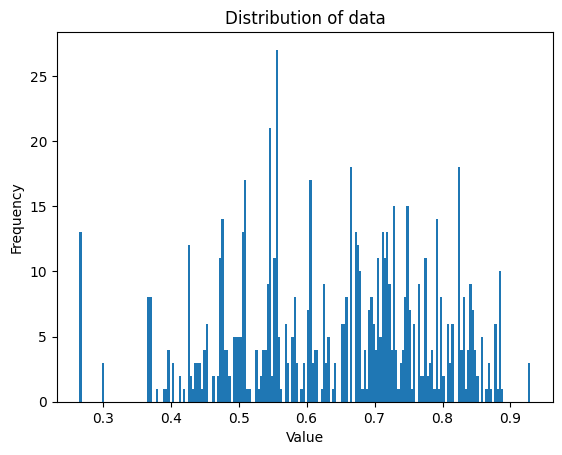

In [159]:
plt.hist(KnowledgeTag_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## userID, assessmentItemID - 1:1 앙상블

In [170]:
ensemble_userID_ItemID_result = []
for _, row in submission_data.iterrows():
    try:
        userID_dict_value = userID_dict[row['userID']]
        assemssmentItemID_value = assessmentItemID_dict[row['assessmentItemID']]
        ensemble_userID_ItemID_result.append(userID_dict_value * 0.5 + assemssmentItemID_value * 0.5)
    except:
        ensemble_userID_ItemID_result.append(np.nan)

csv_save(ensemble_userID_ItemID_result, 'ensemble_userID_ItemID')

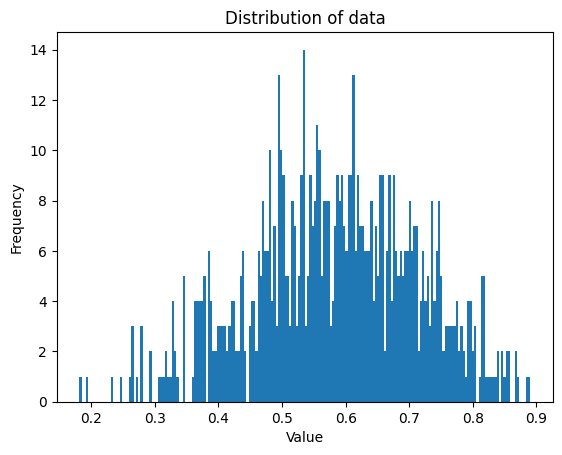

In [172]:
plt.hist(ensemble_userID_ItemID_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## assessmentItemID, KnowledgeTag - 1:1 앙상블 [0.7598, 0.6613]

In [167]:
ensemble_ItemID_Tag_result = []
for _, row in submission_data.iterrows():
    try:
        assemssmentItemID_value = assessmentItemID_dict[row['assessmentItemID']]
        KnowledgeTag_value = KnowledgeTag_dict[row['KnowledgeTag']]
        ensemble_ItemID_Tag_result.append(assemssmentItemID_value * 0.5 + KnowledgeTag_value * 0.5)
    except:
        ensemble_ItemID_Tag_result.append(np.nan)

csv_save(ensemble_ItemID_Tag_result, 'ensemble_ItemID_Tag')

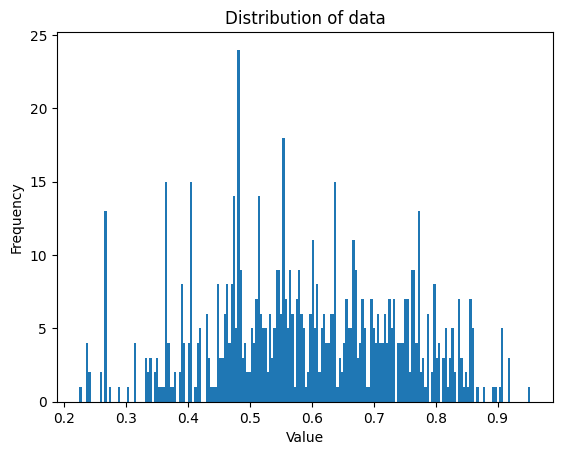

In [169]:
plt.hist(ensemble_ItemID_Tag_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## userID, assessmentItemID, KnowledgeTag - 앙상블
---

userID                 7442

assessmentItemID       9454

KnowledgeTag            912


In [12]:
userID_cnt = 7442
assessmentItemID_cnt = 9454
KnowledgeTag_cnt = 912
all_cnt = userID_cnt + assessmentItemID_cnt + KnowledgeTag_cnt

userID_ratio = userID_cnt / all_cnt
assessmentItemID_ratio = assessmentItemID_cnt / all_cnt
KnowledgeTag_ratio = KnowledgeTag_cnt / all_cnt


ensemble_all_result = []
for _, row in submission_data.iterrows():
    try:
        userID_dict_value = userID_dict[row['userID']]
        assemssmentItemID_value = assessmentItemID_dict[row['assessmentItemID']]
        KnowledgeTag_value = KnowledgeTag_dict[row['KnowledgeTag']]
        ensemble_all_result.append(userID_dict_value * userID_ratio
                                   + assemssmentItemID_value * assessmentItemID_ratio
                                   + KnowledgeTag_value * KnowledgeTag_ratio
                                   )
    except:
        ensemble_all_result.append(np.nan)

csv_save(ensemble_all_result, 'ensemble_all')

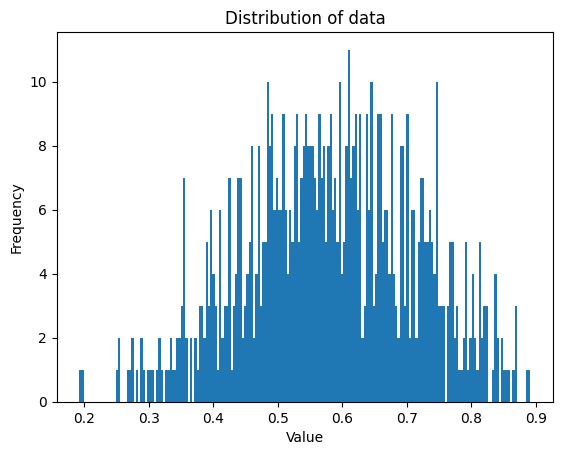

In [13]:
plt.hist(ensemble_all_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [15]:
ANSWER_RATE = 0.5

CORRECT = 1 - ANSWER_RATE
INCORRECT = ANSWER_RATE

cut_50_list = ensemble_all_result
cut_50_result = []

for val in cut_50_list:
    if val < INCORRECT:
        cut_50_result.append(0)
    elif val > CORRECT:
        cut_50_result.append(1)
    else:
        cut_50_result.append(val)

csv_save(cut_50_result, 'cut_50_result')

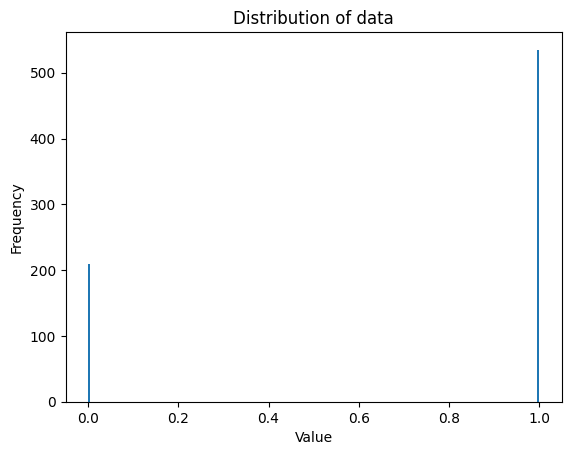

In [17]:
plt.hist(cut_50_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## subplot 정리

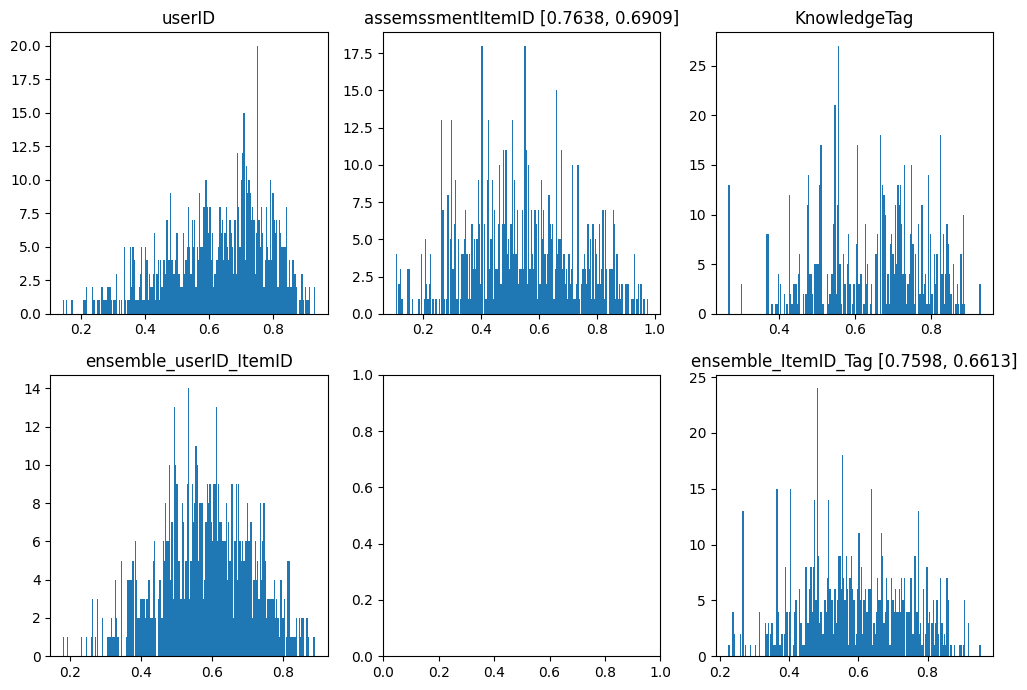

In [201]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))  # 2행 2열 subplot 생성

# 각각의 subplot에 리스트 데이터를 그래프로 출력
axs[0, 0].hist(userID_result, bins=200)
axs[0, 0].set_title('userID')

axs[0, 1].hist(assemssmentItemID_result, bins=200)
axs[0, 1].set_title('assemssmentItemID [0.7638, 0.6909]')

axs[0, 2].hist(KnowledgeTag_result, bins=200)
axs[0, 2].set_title('KnowledgeTag')

axs[1, 0].hist(ensemble_userID_ItemID_result, bins=200)
axs[1, 0].set_title('ensemble_userID_ItemID')

axs[1, 2].hist(ensemble_ItemID_Tag_result, bins=200)
axs[1, 2].set_title('ensemble_ItemID_Tag [0.7598, 0.6613]')

plt.tight_layout()  # subplot간 간격 조절
plt.show()

## 문제 정답률 처리

---

보통 20~30% 이하의 정답률을 가진 문제들을 킬러문제라고 함

그러면 양 끝단 20~30%의 경우 0이나 1로 cut해줘도 되지 않을까

### cut 20%

In [194]:
ANSWER_RATE = 0.2

CORRECT = 1 - ANSWER_RATE
INCORRECT = ANSWER_RATE

cut_20_list = assemssmentItemID_result
cut_20_result = []

for val in cut_20_list:
    if val <= INCORRECT:
        cut_20_result.append(0)
    elif val >= CORRECT:
        cut_20_result.append(1)
    else:
        cut_20_result.append(val)

csv_save(cut_20_result, 'cut_20_result')

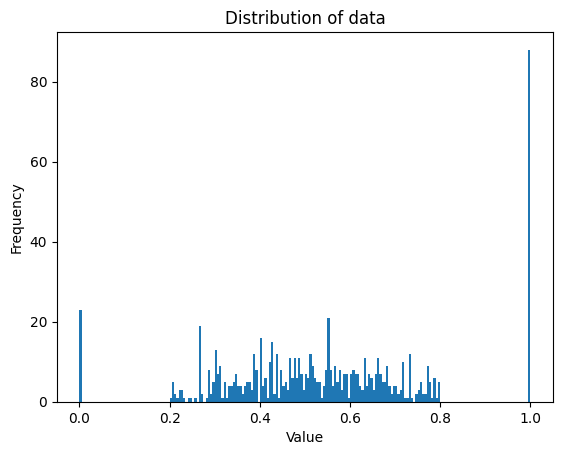

In [187]:
plt.hist(cut_20_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### cut 30%

In [193]:
ANSWER_RATE = 0.3

CORRECT = 1 - ANSWER_RATE
INCORRECT = ANSWER_RATE

cut_30_list = assemssmentItemID_result
cut_30_result = []

for val in cut_30_list:
    if val <= INCORRECT:
        cut_30_result.append(0)
    elif val >= CORRECT:
        cut_30_result.append(1)
    else:
        cut_30_result.append(val)

csv_save(cut_30_result, 'cut_30_result')

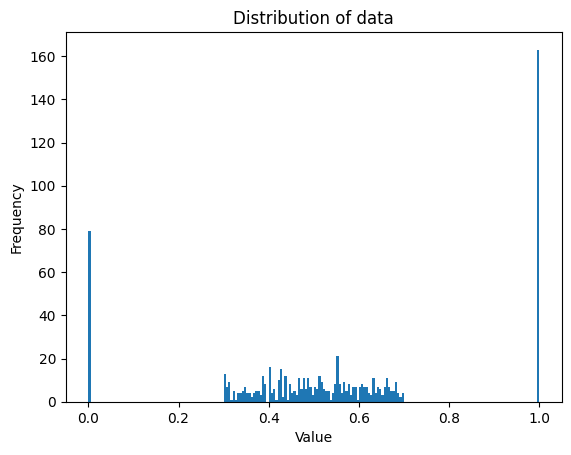

In [189]:
plt.hist(cut_30_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## cut 50%

In [30]:
ANSWER_RATE = 0.5

CORRECT = 1 - ANSWER_RATE
INCORRECT = ANSWER_RATE

cut_50_list = assemssmentItemID_result
cut_50_result = []

for val in cut_50_list:
    if val < INCORRECT:
        cut_50_result.append(0)
    elif val > CORRECT:
        cut_50_result.append(1)
    else:
        cut_50_result.append(val)

csv_save(cut_50_result, 'cut_50_result')

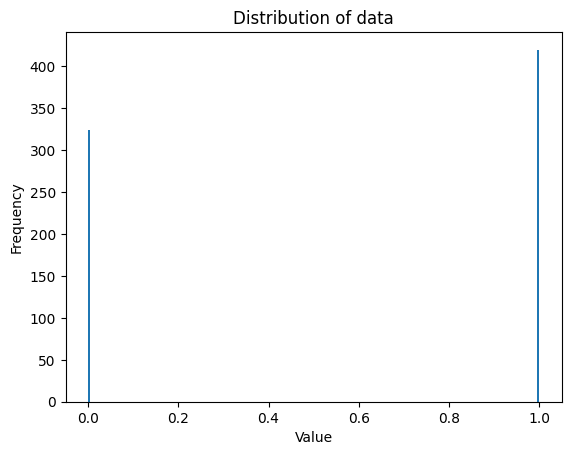

In [31]:
plt.hist(cut_50_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## 문제를 잘 못푸는 사람에 대한 생각

In [28]:
cut_50_User = userID_result
cut_50_Item = assemssmentItemID_result
cut_intelli_result = []

for user, item in zip(cut_50_User, cut_50_Item):
    if item < 0.7:
        if user < 0.3:
            cut_intelli_result.append(0)
        elif item < 0.5:
            cut_intelli_result.append(0)
        else:
            cut_intelli_result.append(1)
    else:
        cut_intelli_result.append(1)

csv_save(cut_intelli_result, 'cut_intelli_result')

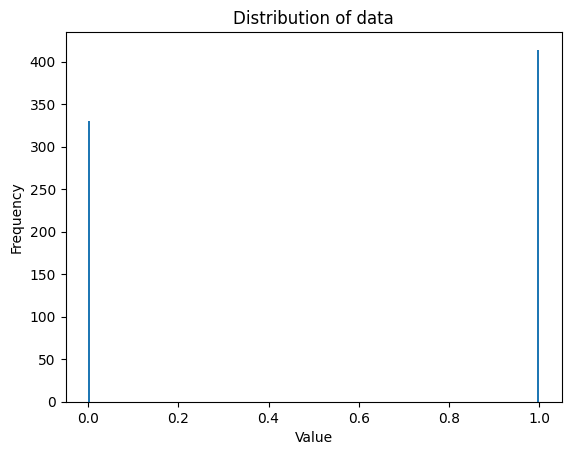

In [29]:
plt.hist(cut_intelli_result, bins=200)
plt.title('Distribution of data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()